In [1]:
from DataUtils2 import DataInterface
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d;

%matplotlib inline

In [2]:
class SensorReader:
    def __init__(self, radiusOfEarth, encoder_resolution, encoder_diameterL, encoder_diameterR):
        self.data_interface = DataInterface(
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/gps.csv",
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/xsens_imu.csv",
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/sensor_data/encoder.csv",
            "/home/an/workspace/Classes/Spring 2022/CS-179/Project/urban16/global_pose.csv"
        )
        # data -> (lon,lat,alt,left,right,yaw,pitch,roll)
        self.R = radiusOfEarth
        self.res = encoder_resolution
        self.angle_to_rad = np.pi/180
        self.enc_radL = encoder_diameterL / 2
        self.enc_radR = encoder_diameterR / 2
        
        self.init_data = self.parse(self.data_interface.read())
        self.meas = self.init_data.copy()
        self.meas[0:5] = 0 #re-init
        
        t = self.data_interface.get_ground_truth()
        self.t0 = t.copy()
        
    def parse(self, data):
        gps = data['gps_data']
        imu = data['imu_data']
        enc = data['encoders_data']
        lat,lon,alt = gps[1:4]
        pitch, roll, yaw = imu[5:8]
        left,right = enc[1:3]
        
        lat = lat*np.pi/180*self.R
        lon = lon*np.pi/180*self.R
        left = left * 2*np.pi/self.res * self.enc_radL
        right = right * 2*np.pi/self.res * self.enc_radR
        
        return np.array([[lon,lat,alt,left,right,yaw,pitch,roll]]).T
    def read(self):
        self.meas = self.parse(self.data_interface.read())
        self.meas[0:5] -= self.init_data[0:5]
        return self.meas
    def getGT(self):
        t = self.data_interface.get_ground_truth() - self.t0
        return t

In [3]:
class KalmanSmoother:
    def __init__(self, A,C,Q,R, init0):
        self.A = A
        self.C = C
        self.Q = Q
        self.R = R

        self.mu = init0
        self.cov = np.eye(3)
        self.Kt = np.eye(3)
        
        self.muSave = self.mu.copy()
        self.covSave = self.cov.copy()
    def predict(self):
        self.mu_pred = self.A @ self.mu
        self.cov_pred = self.A @ self.cov @ self.A.T + self.R
        self.Kt = self.cov_pred @ self.C.T @ np.linalg.inv(self.C @ self.cov_pred @ self.C.T + self.Q)
    def correct(self, meas):
        self.mu = self.mu_pred + self.Kt @ (meas - self.C @ self.mu_pred)
        self.cov = (np.eye(3) - self.Kt@self.C) @ self.cov_pred
    def estimate(self, meas):
        self.predict()
        self.correct(meas)
        
        self.muSave = np.hstack((self.muSave, self.mu))
        self.covSave = np.hstack((self.covSave, self.cov))
    def smooth(self): # backward pass
        n = self.muSave.shape[1]
        
        for i in range(n-2,-1,-1):
            var = self.covSave[:,3*i:3*i+3]
            L = var @ self.A.T @ np.linalg.inv(self.A @ var @ self.A.T + self.Q)
            mu = self.muSave[:,i]
            self.muSave[:,i] = mu + L @ (self.muSave[:,i+1] - self.A @ mu)
            self.covSave[:,3*i:3*i+3] = var + L @ (self.covSave[:,3*i+3:3*i+6] - (self.A @ var @ self.A.T))@L.T

In [4]:
R = 6_371_000 #earth's radius in meters
encDiamL = 0.623022
encDiamR = 0.622356
res = 4096
wheelbase = 1.5285

sensors = SensorReader(R, res, encDiamL, encDiamR)

init0 = sensors.read()
gt = sensors.getGT()

In [5]:
print(init0[:3,:])
print(gt)

[[ 0.03335848]
 [-0.04447797]
 [ 0.062     ]]
[[0.]
 [0.]
 [0.]]


In [6]:
A = np.eye(3)
C = np.eye(3)
Q = np.eye(3)
R = np.eye(3)


start_mu = init0[:3,:]
kal = KalmanSmoother(A,C,Q,R,start_mu)

In [7]:
data_GT = init0[:3,:]
for i in range(1_000):
    data = sensors.read()[:3,:]
    data_GT = np.hstack((data_GT, data))
    kal.estimate(data)

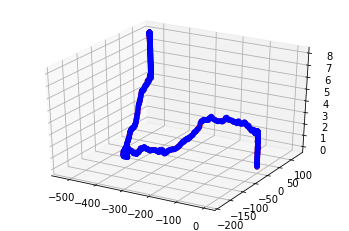

In [8]:
data = kal.muSave
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data[0,:], data[1,:], data[2,:], c='red')
ax.scatter(data_GT[0,:], data_GT[1,:], data_GT[2,:], c='blue')
plt.show()

In [9]:
data.shape

(3, 1001)

In [10]:
data_GT.shape

(3, 1001)

In [11]:
MSE = (np.linalg.norm(data - data_GT ,axis=0)**2).mean()
print(MSE)

0.5523953284650658


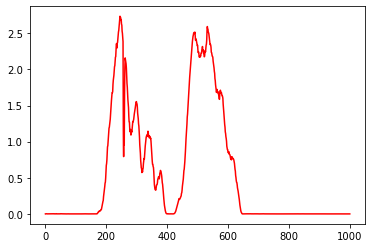

In [12]:
error = (np.linalg.norm(data - data_GT ,axis=0)**2)
t = np.arange(error.shape[0])
plt.plot(t, error, color='red')

In [13]:
kal.smooth()

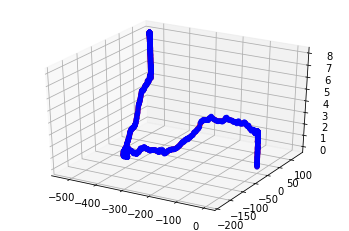

In [15]:
data = kal.muSave
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(data[0,:], data[1,:], data[2,:], c='red')
ax.scatter(data_GT[0,:], data_GT[1,:], data_GT[2,:], c='blue')
plt.show()

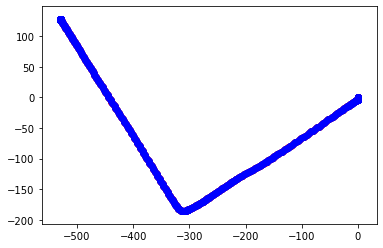

In [19]:
plt.scatter(data[0,:], data[1,:],c='red')
plt.scatter(data_GT[0,:], data_GT[1,:], c='blue')
plt.show()

In [17]:
MSE = (np.linalg.norm(data - data_GT ,axis=0)**2).mean()
print(MSE)

0.0016606194543213205


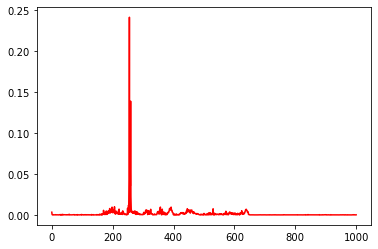

In [18]:
error = (np.linalg.norm(data - data_GT ,axis=0)**2)
t = np.arange(error.shape[0])
plt.plot(t, error, color='red')